# **Revenue Prediction**
**The client is facing difficulties in accurately predicting future revenue, which is crucial for effective strategic planning, budgeting, and resource management. Current revenue forecasting methods are limited to basic historical trends and do not incorporate dynamic variables such as customer behavior, market conditions, and economic changes. This leads to unreliable revenue predictions, impacting decision-making processes and overall business performance. The client needs a more advanced predictive model that can accurately forecast revenue by analyzing a wide range of data inputs, enabling better financial planning and strategy formulation.**


###Imported necessary libraries

In [104]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


### Data Merging Process
Merged multiple datasets on `id` and `score_date` to create a comprehensive dataset combining customer details, feedback, utilization, expansion outcomes, and product information.


In [105]:
customer = pd.read_csv("customer.csv")
customer_feedback = pd.read_csv("customer_feedback.csv")
utilization = pd.read_csv("utilization.csv")
expansion_outcome = pd.read_csv("expansion_outcome.csv")
product = pd.read_csv("product.csv")

df = expansion_outcome.merge(customer_feedback, on=["id", "score_date"])
df = df.merge(utilization, on=["id", "score_date"])
df = df.merge(customer, on=["id", "score_date"])
df = df.merge(product, on=["id", "score_date"])
df.to_csv('final.csv',index=False)
print("Final merged dataset shape:", df.shape)

Final merged dataset shape: (13417, 55)


In [106]:
df.head()

,id,score_date,current_arr,future_arr,arr_change,fx_impact,seat_change_arr,product_change_arr,csat_score,csat_response_rate,...,crm_industry_current,crm_employee_range,crm_success_owner_change,discount_arr_usd,team_plus,pro_plus,ent_plus,discount_arr_usd_percentage,product_counts_percentage,total_pool_max_agents
0,JMAN_2429072,10-02-2023,2976.00,2976.00,0.00,0.00,0.0,0.00,100,33,...,"Retail, Wholesale & Distribution",100 - 249,0,0.0,1,1,0,100,100,0
1,JMAN_9043466,13-01-2023,20724.72,21474.84,499.56,250.56,0.0,499.56,100,17,...,"Retail, Wholesale & Distribution",250 - 499,0,0.0,1,1,1,100,100,0
2,JMAN_2452556,24-02-2023,605.76,817.80,181.92,30.12,0.0,0.00,0,0,...,NaN,01-Sep,0,0.0,1,1,1,100,100,0
3,JMAN_2455113,03-03-2023,300.00,300.00,0.00,0.00,0.0,0.00,0,0,...,NaN,01-Sep,0,0.0,1,0,0,100,100,0
4,JMAN_18127937,10-02-2023,2100.00,420.00,-1680.00,0.00,-1680.0,0.00,0,0,...,NaN,01-Sep,0,0.0,1,1,0,100,100,0


### Data Cleaning

- **Filled missing values in `max_seats` with 0** to handle null entries(one null).  
- **Converted `score_date` to datetime format (`%d-%m-%Y`)** for proper date handling.  
- **Replaced missing values in `crm_industry_current` with 'other'** to maintain consistency.  
- **Calculated `future_arr`** by filling missing values with the sum of `current_arr`, `arr_change`, and `fx_impact`, ensuring no null values in revenue-related fields.  


In [107]:
df['max_seats'] = df['max_seats'].fillna(0)
df['score_date'] = pd.to_datetime(df['score_date'], format='%d-%m-%Y')
df['crm_industry_current'] = df['crm_industry_current'].fillna('other')
df['future_arr'] = df['future_arr'].fillna(df['current_arr'].fillna(0)+df['arr_change'].fillna(0)+df['fx_impact'].fillna(0))

### Exploratory Data Analysis (EDA)

### Hypothesis 1

- **Null Hypothesis (H₀)**: There is no significant correlation between the number of max seats and future ARR (i.e., max seats do not impact future ARR).  
- **Alternate Hypothesis (H₁)**: There is a significant positive correlation between the number of max seats and future ARR (i.e., as max seats increase, future ARR also increases).  


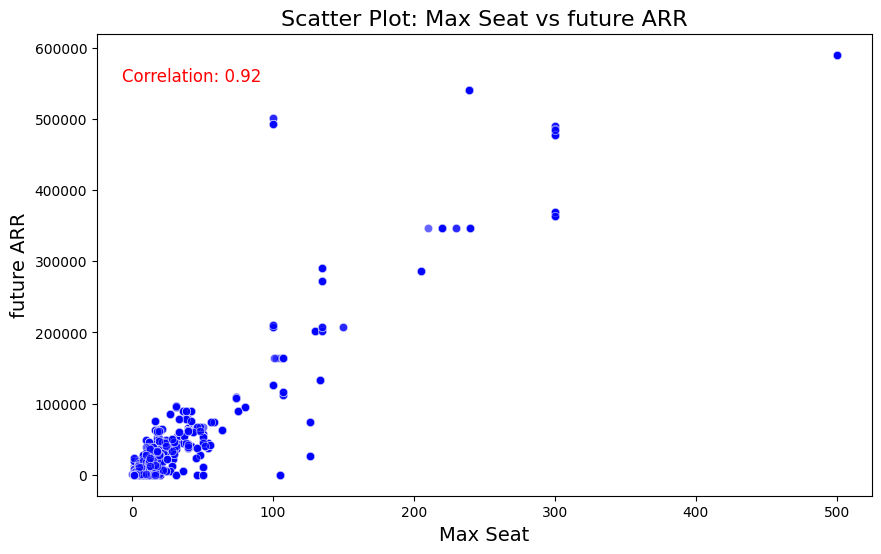

In [108]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='max_seats', y='future_arr', data=df, alpha=0.6, color='b')
plt.title(f'Scatter Plot: Max Seat vs future ARR', fontsize=16)
plt.xlabel('Max Seat', fontsize=14)
plt.ylabel('future ARR', fontsize=14)
correlation = df['max_seats'].corr(df['future_arr'])
plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='red')
plt.show()

### Hypothesis 2

- **Null Hypothesis (H₀)**: Customer age (in quarters) has no significant impact on future ARR.  
- **Alternate Hypothesis (H₁)**: Customers who stay longer (higher age in quarters) contribute more to future ARR.  


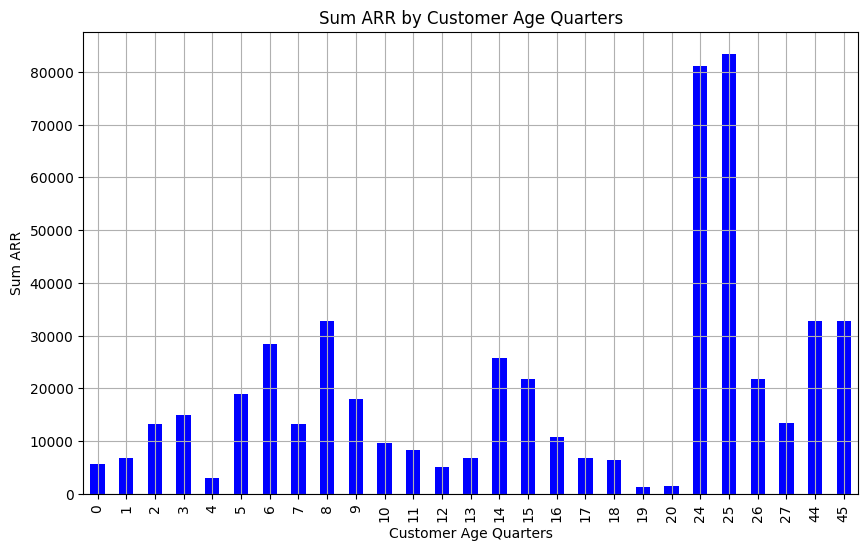

In [109]:
mean_arr_by_month = df.groupby('customer_age_quarters')['future_arr'].mean()
plt.figure(figsize=(10,6))
mean_arr_by_month.plot(kind='bar', color='blue')
plt.title('Sum ARR by Customer Age Quarters')
plt.xlabel('Customer Age Quarters')
plt.ylabel('Sum ARR')
plt.grid(True)
plt.show()



### Hypothesis 3  

- **Null Hypothesis (H₀)**: The number of high-severity outages does not significantly impact the CSAT score, and thus has no indirect impact on future ARR.  
- **Alternate Hypothesis (H₁)**: A higher number of high-severity outages leads to lower CSAT scores, which in turn negatively impacts future ARR.  


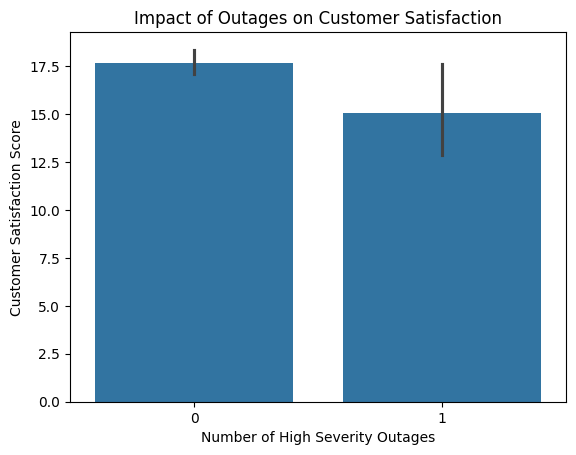

In [110]:
sns.barplot(x=df['num_high_sev_outages'], y=df['csat_score'])
plt.xlabel("Number of High Severity Outages")
plt.ylabel("Customer Satisfaction Score")
plt.title("Impact of Outages on Customer Satisfaction")
plt.show()

### Hypothesis 4

- **Null Hypothesis (H₀)**: CSAT score has no significant impact on future ARR.  
- **Alternate Hypothesis (H₁)**: Higher CSAT scores are associated with higher future ARR.  


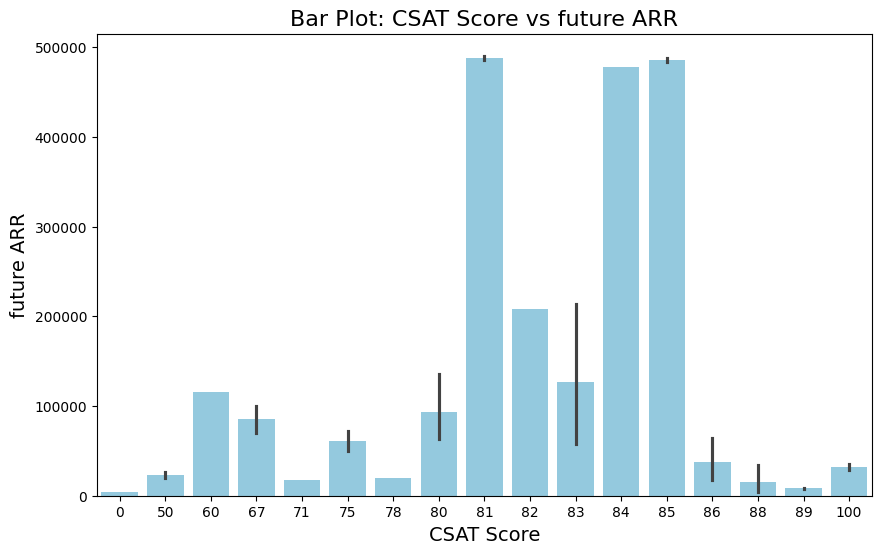

In [111]:
plt.figure(figsize=(10, 6))
sns.barplot(x='csat_score', y='future_arr', data=df, color='skyblue')
plt.title('Bar Plot: CSAT Score vs future ARR', fontsize=16)
plt.xlabel('CSAT Score', fontsize=14)
plt.ylabel('future ARR', fontsize=14)
plt.show()

### Hypothesis 5

- **Null Hypothesis (H₀)**: Customer tier has no significant impact on future ARR.  
- **Alternate Hypothesis (H₁)**: Higher-tier customers (Enterprise Plus > Pro Plus > Team Plus) contribute more to future ARR compared to lower-tier (Basic) customers.  


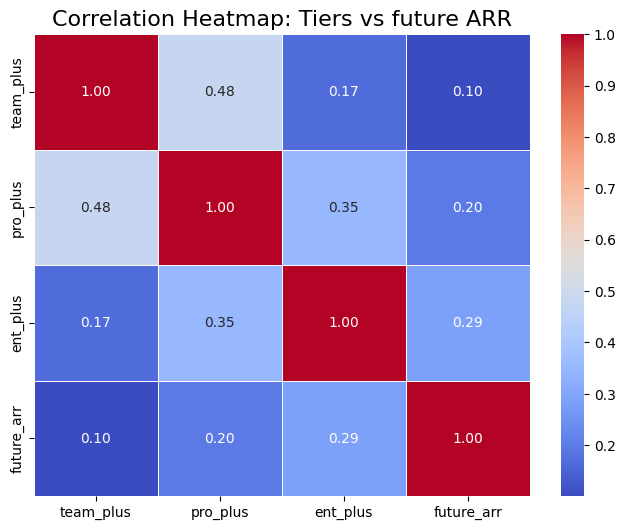

In [112]:
plt.figure(figsize=(8, 6))
corr = df[['team_plus', 'pro_plus', 'ent_plus', 'future_arr']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Tiers vs future ARR', fontsize=16)
plt.show()

In [113]:
def assign_tier(row):
    if row['ent_plus'] == 1:
        return 'Enterprise Plus'
    elif row['pro_plus'] == 1:
        return 'Pro Plus'
    elif row['team_plus'] == 1:
        return 'Team Plus'
    else:
        return 'Basic'
df['tier'] = df.apply(assign_tier, axis=1)

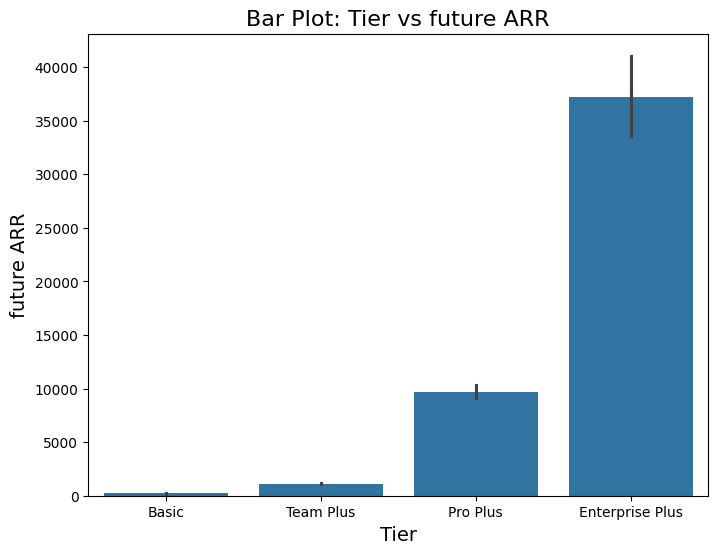

In [114]:
plt.figure(figsize=(8, 6))
sns.barplot(x='tier', y='future_arr', data=df, order=['Basic', 'Team Plus', 'Pro Plus', 'Enterprise Plus'])
plt.title('Bar Plot: Tier vs future ARR', fontsize=16)
plt.xlabel('Tier', fontsize=14)
plt.ylabel('future ARR', fontsize=14)
plt.show()

### Hypothesis 6

- **Null Hypothesis (H₀)**: The region a customer belongs to has no significant impact on future ARR.  
- **Alternate Hypothesis (H₁)**: Customers from certain regions contribute more to future ARR compared to others.  


In [115]:
def assign_region(row):
    if row['region_emea'] == 1:
        return 'EMEA'
    elif row['region_apac'] == 1:
        return 'APAC'
    elif row['region_latam'] == 1:
        return 'LATAM'
    elif row['region_amer'] == 1:
        return 'AMER'

df['region'] = df.apply(assign_region, axis=1)


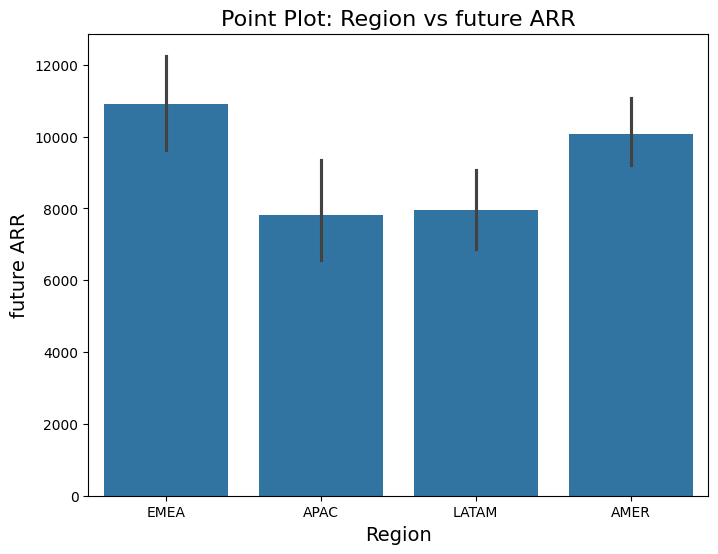

In [116]:
plt.figure(figsize=(8, 6))
sns.barplot(x='region', y='future_arr', data=df, order=['EMEA', 'APAC', 'LATAM', 'AMER'])
plt.title('Point Plot: Region vs future ARR', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('future ARR', fontsize=14)
plt.show()


### Hypothesis 7

- **Null Hypothesis (H₀)**: Customer segment has no significant impact on future ARR.  
- **Alternate Hypothesis (H₁)**: Certain customer segments (e.g., Enterprise or Commercial) contribute more to future ARR compared to others (e.g., SMB or Midmarket).  


In [117]:
df['segment'] = df[['segment_smb','segment_midmarket', 'segment_enterprise', 'segment_commercial']].idxmax(axis=1)
df['segment'] = df['segment'].str.replace('segment_', '')

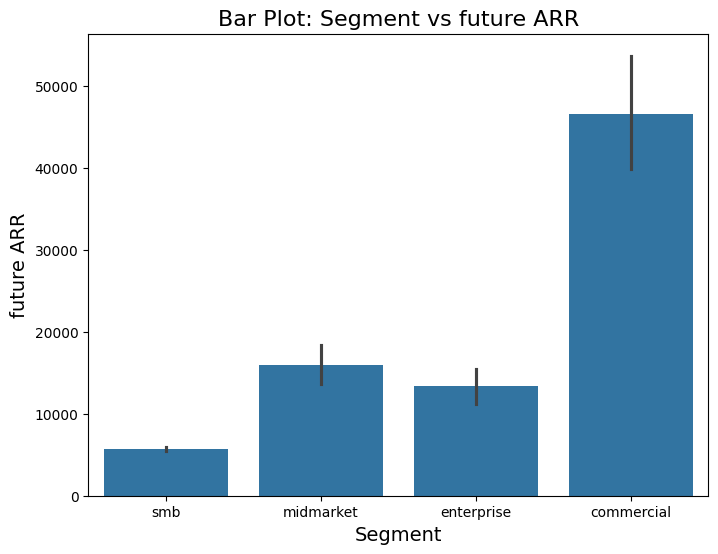

In [118]:
plt.figure(figsize=(8, 6))
sns.barplot(x='segment', y='future_arr', data=df, order=['smb','midmarket', 'enterprise', 'commercial'])
plt.title('Bar Plot: Segment vs future ARR', fontsize=16)
plt.xlabel('Segment', fontsize=14)
plt.ylabel('future ARR', fontsize=14)
plt.show()


### Hypothesis for SMB vs Non-SMB Future ARR  

- **Null Hypothesis (H₀)**: There is no significant difference in future ARR between SMB and Non-SMB customers.  
- **Alternate Hypothesis (H₁)**: Non-SMB customers contribute more to future ARR compared to SMB customers.  


<ipython-input-119-3881812dc50b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Customer Type', y='Future ARR', data=arr_summary, palette='viridis')


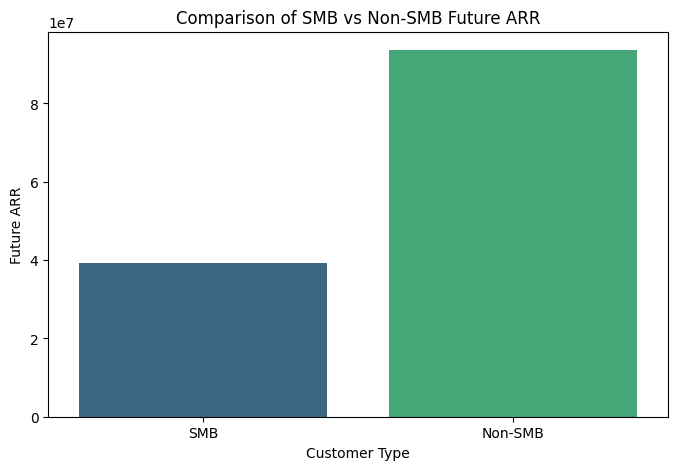

In [119]:
smb_arr = df.loc[df['segment_smb'] == 1, 'future_arr'].sum()
non_smb_arr = df.loc[df['segment_non_smb'] == 1, 'future_arr'].sum()
arr_summary = pd.DataFrame({
    'Customer Type': ['SMB', 'Non-SMB'],
    'Future ARR': [smb_arr, non_smb_arr]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Customer Type', y='Future ARR', data=arr_summary, palette='viridis')
plt.xlabel("Customer Type")
plt.ylabel("Future ARR")
plt.title("Comparison of SMB vs Non-SMB Future ARR")
plt.show()

### Hypothesis 8

- **Null Hypothesis (H₀)**: The CRM industry of a customer has no significant impact on future ARR.  
- **Alternate Hypothesis (H₁)**: Certain CRM industries contribute more to future ARR compared to others.  


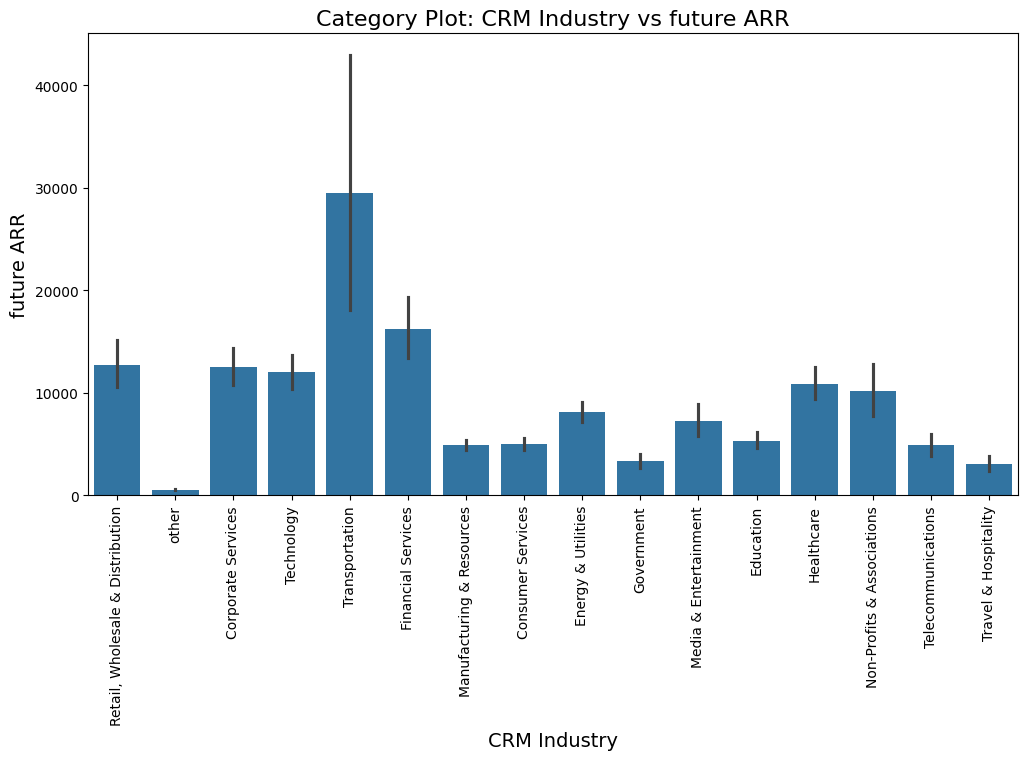

In [120]:
plt.figure(figsize=(12, 6))
sns.barplot(x='crm_industry_current', y='future_arr', data=df)
plt.title('Category Plot: CRM Industry vs future ARR', fontsize=16)
plt.xlabel('CRM Industry', fontsize=14)
plt.ylabel('future ARR', fontsize=14)
plt.xticks(rotation=90)
plt.show()


### Hypothesis 9

- **Null Hypothesis (H₀)**: The number of products a customer uses has no significant impact on future ARR.  
- **Alternate Hypothesis (H₁)**: Customers using more products contribute more to future ARR.  


<ipython-input-121-0282762e1088>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_counts = df.groupby('product_counts')['future_arr'].sum().reset_index()


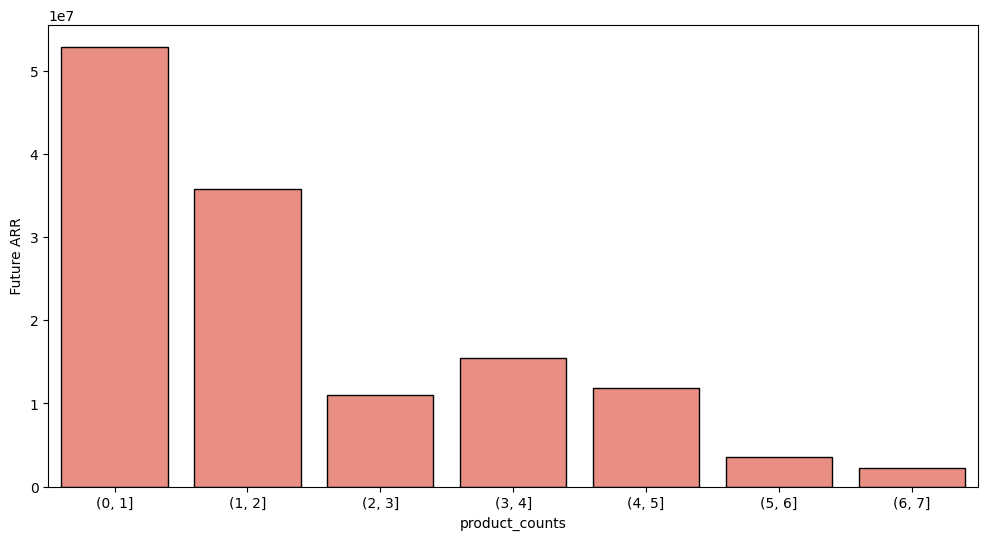

In [121]:
df['product_counts'] = pd.cut(
    df['product_counts'],
    bins=[0,1,2,3,4,5,6,7]
)
product_counts = df.groupby('product_counts')['future_arr'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    x='product_counts',
    y='future_arr',
    data=product_counts,
    color='salmon',
    edgecolor='black'
)
plt.ylabel(' Future ARR ')
plt.show()

### Hypothesis 10

- **Null Hypothesis (H₀)**: Billing issues do not significantly impact future ARR. Customers with and without billing issues have similar future ARR.  
- **Alternate Hypothesis (H₁)**: Customers with billing issues tend to have lower future ARR compared to those without billing issues.  


<ipython-input-122-ebd0439418e4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Billing Issues', y='Average Future ARR', data=billing_impact, palette=['green', 'red'])


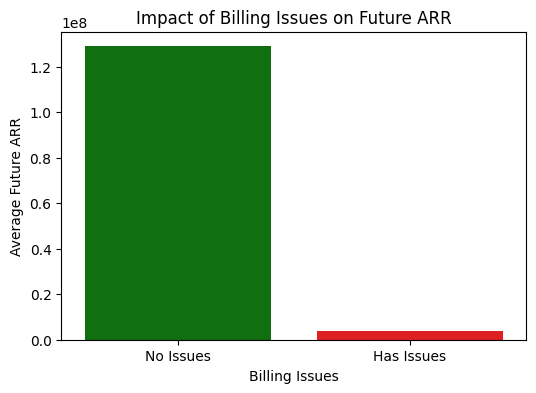

In [122]:
arr_no_billing_issues = df.loc[df['billing_dunning_not_ok'] == 0, 'future_arr'].sum()
arr_with_billing_issues = df.loc[df['billing_dunning_not_ok'] == 1, 'future_arr'].sum()

billing_impact = pd.DataFrame({
    'Billing Issues': ['No Issues', 'Has Issues'],
    'Average Future ARR': [arr_no_billing_issues, arr_with_billing_issues]
})

plt.figure(figsize=(6, 4))
sns.barplot(x='Billing Issues', y='Average Future ARR', data=billing_impact, palette=['green', 'red'])
plt.title('Impact of Billing Issues on Future ARR')
plt.xlabel('Billing Issues')
plt.ylabel('Average Future ARR')
plt.show()


### Hypothesis 11
* **Null Hypothesis (H₀)**: The number of provisioning channels in prior months has no significant impact on future ARR.

* **Alternate Hypothesis (H₁)**: A higher number of provisioning channels in prior months is associated with changes in future ARR.

Text(0.5, 1.0, 'Relationship Between Provisioning and Future Revenue')

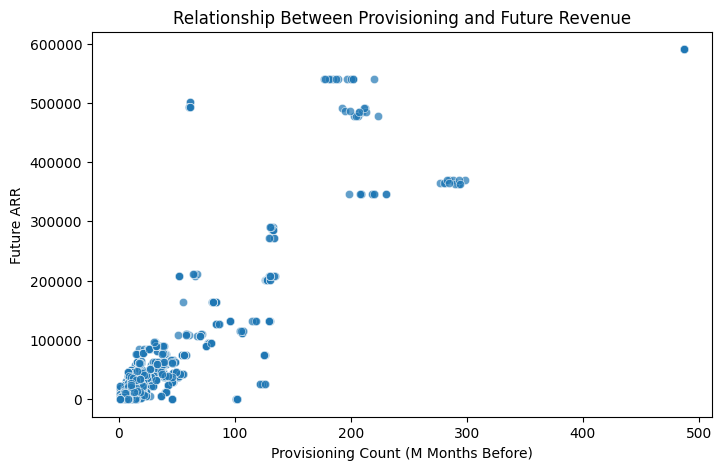

In [123]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="is_provisioned_any_channel_M_before", y="future_arr", data=df, alpha=0.7)
plt.xlabel("Provisioning Count (M Months Before)")
plt.ylabel("Future ARR")
plt.title("Relationship Between Provisioning and Future Revenue")

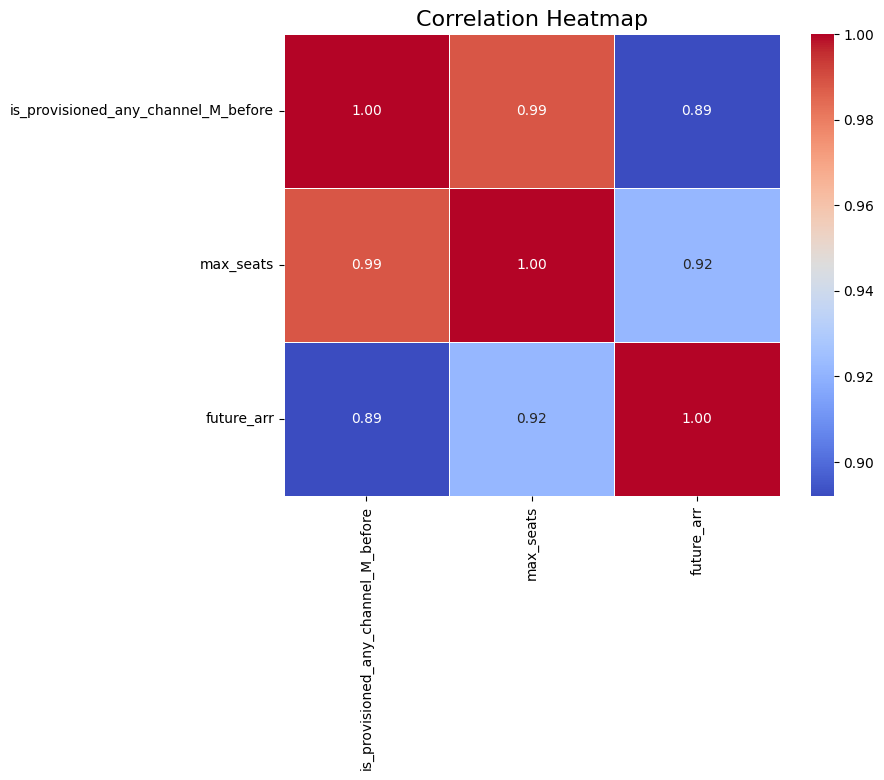

In [124]:
plt.figure(figsize=(8, 6))
corr = df[['is_provisioned_any_channel_M_before','max_seats', 'future_arr']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

## Feature Creation and Bucketing
* **Long-Term Customer**: A binary feature indicating whether a customer has been
active for longer than the median customer age in quarters.

* **High CSAT Score**: A binary feature that identifies customers with a CSAT score above the median, indicating high satisfaction levels.

* **High Product Usage**: A binary feature that flags customers using more products than the median, representing higher engagement.

* **Ticket Volume Bucketing**: The `max_tickets_per_agent` column is categorized into five ranges (0-5k, 5k-10k, 10k-15k, 15k-20k, 20k+), allowing analysis of ticket workload impact.

* **Seat Utilization Bucketing**: The `max_seats` column is binned into five groups (0-100, 100-200, 200-300, 300-400, 400-500) to assess how seat allocation relates to future ARR.

In [125]:
df['long_term_customer'] = (df['customer_age_quarters'] > df['customer_age_quarters'].median()).astype(int)
df['high_csat'] = (df['csat_score'] > df['csat_score'].median()).astype(int)
# df['high_product_usage'] = (df['product_counts'] > df['product_counts'].median()).astype(int)
df['ticket_range'] = pd.cut(
    df['max_tickets_per_agent'],
    bins=[0, 5000, 10000, 15000, 20000, np.inf],
    labels=['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k+'],
    right=False
)
df['seat_range'] = pd.cut(
    df['max_seats'],
    bins=[0, 100, 200, 300, 400, 500],
    labels=['0-100', '100-200', '200-300', '300-400', '400-500'],
    right=False
)

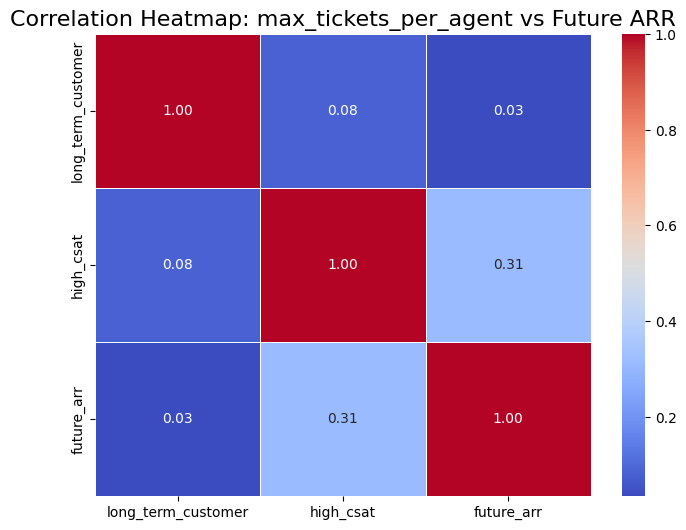

In [126]:
plt.figure(figsize=(8, 6))
corr = df[['long_term_customer'	,'high_csat',	'future_arr']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: max_tickets_per_agent vs Future ARR', fontsize=16)
plt.show()

## Feature Selection and Data Splitting

We are selecting key features to predict **Future ARR (Annual Recurring Revenue)**.  
The dataset includes attributes such as **maximum seats, CSAT score, customer segment, and region**.

- **`X`**: Independent variables used for training the model.
- **`y`**: Target variable (`future_arr`).
- **Data Splitting**: We split the data into an **80% training set** and a **20% test set** using `train_test_split`

In [127]:
# train the model
X = df[['max_seats', 'csat_score', 'team_plus', 'pro_plus', 'ent_plus', 'future_arr','segment_smb','segment_midmarket', 'segment_enterprise', 'segment_commercial', 'region_emea', 'region_latam', 'region_apac','region_amer','billing_dunning_not_ok']].copy()
y = X.pop('future_arr')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Model Training  
### Linear Regression Model

We are using **Linear Regression** to predict **Future ARR**. The model is trained using the `fit()` method on the training dataset.

- **Algorithm**: Linear Regression
- **Training Data**: `X_train` (features) and `y_train` (target variable)
- **Objective**: Learn the relationship between customer attributes and future ARR.


In [128]:
model=LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Model Evaluation

After training our **Linear Regression** model, we now evaluate its performance using key regression metrics.

### Predictions on Test Data
We generate predictions using the trained model on the test dataset (`X_test`).

### Error Metrics
To measure the accuracy of our predictions, we compute the following metrics:

- **Mean Squared Error (MSE):**  Measures the average squared difference between actual and predicted values. Lower values indicate better performance.  
- **Root Mean Squared Error (RMSE):**  A more interpretable version of MSE, as it is in the same unit as the target variable.  
- **Mean Absolute Error (MAE):**  Measures the average absolute difference between actual and predicted values, making it easy to interpret.  

### Model Performance Interpretation
- **R² Score:**  Indicates the proportion of variance in `future_arr` explained by the model.  
- **Adjusted R² Score:**  Adjusts R² for the number of predictors to avoid overfitting.  

### Key Insights
- **Low RMSE & MAE:** Indicates the model makes accurate predictions.  
- **High R² & Adjusted R²:** Shows the model explains most revenue variations.  


In [129]:
# Predictions

y_pred = model.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R2 Score: {r2:.2f}')
print(f'Adjusted R2 Score: {adjusted_r2:.2f}')


Mean Squared Error (MSE): 170235117.85
Root Mean Squared Error (RMSE): 13047.42
Mean Absolute Error (MAE): 5212.83
R2 Score: 0.89
Adjusted R2 Score: 0.89


In [130]:
X_train.columns

Index(['max_seats', 'csat_score', 'team_plus', 'pro_plus', 'ent_plus',
       'segment_smb', 'segment_midmarket', 'segment_enterprise',
       'segment_commercial', 'region_emea', 'region_latam', 'region_apac',
       'region_amer', 'billing_dunning_not_ok'],
      dtype='object')

In [131]:
model.coef_

array([ 1338.85099533,    35.21167888,  -589.73675912,   874.67473899,
        8386.53945638, -3018.13247394,  -353.44782799, -3739.44156607,
        3932.05142227,  1681.81001479, -3162.04919853,  1307.96569049,
         172.27349325, -6991.69775408])

## Cross-Validation for Model Evaluation

To ensure our model generalizes well to unseen data, we use **k-fold cross-validation**. This helps us assess model performance across different data splits and avoid overfitting.


In [132]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores):.2f}")

Cross-Validation R2 Scores: [0.83991262 0.89614367 0.82269    0.90936206 0.85536444]
Mean CV R2 Score: 0.86


## Predicting Future ARR for a New Data Point  

- We use the trained model to predict **future ARR** for new customer data.  
- A new data point is created with the same feature structure as the training data.  
- The model predicts the **expected future ARR** based on the given inputs.  


In [134]:
#10080

print(list(X.columns))
feature_names = X_train.columns.tolist()
X_new = pd.DataFrame([[10, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,0]], columns=feature_names)
y_new_pred = model.predict(X_new)
print("Predicted Value:", y_new_pred)

['max_seats', 'csat_score', 'team_plus', 'pro_plus', 'ent_plus', 'segment_smb', 'segment_midmarket', 'segment_enterprise', 'segment_commercial', 'region_emea', 'region_latam', 'region_apac', 'region_amer', 'billing_dunning_not_ok']
Predicted Value: [9994.66176494]


### Hyper parameter tuning for linear regression

In [135]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_no_scaling = Pipeline([
    ('model', LinearRegression())
])

pipeline_with_scaling = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])


param_grid = [
    {'model': [LinearRegression()]},
    {'scaler': [StandardScaler()], 'model': [LinearRegression()]}
]

grid_search = GridSearchCV(Pipeline([('scaler', None), ('model', LinearRegression())]),
                           param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best R² Score on Training Data:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test R² Score:", r2_score(y_test, y_pred))


Best Params: {'model': LinearRegression()}
Best R² Score on Training Data: 0.8513165635936562
Test R² Score: 0.8851654975075789


### Shap Value to visualize feature importance

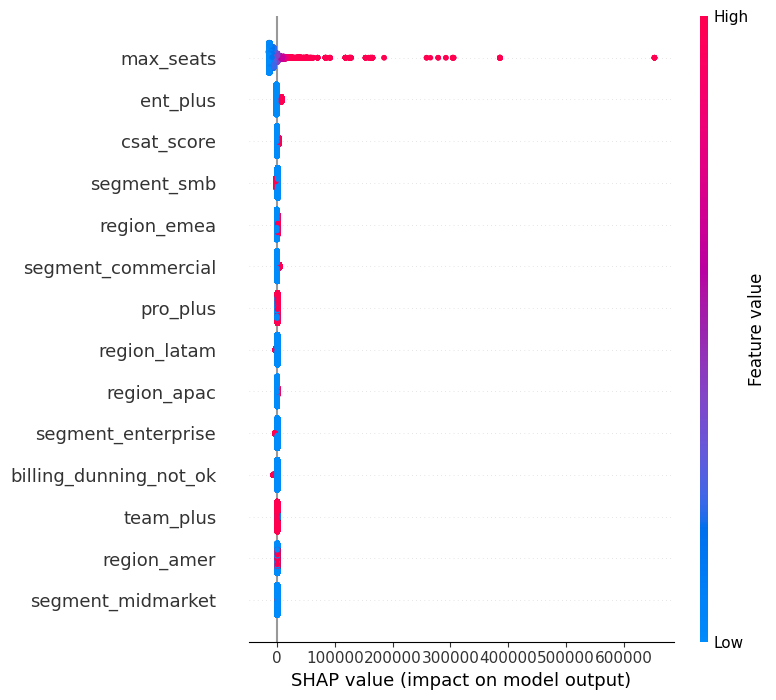

In [136]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

### Decision Tree Model
We use a Decision Tree Regressor with a maximum depth of 5 to prevent overfitting.

* The model is trained using the X_train (features) and y_train (target).

* **Evaluating the Model**
After making predictions (y_pred_tree), we measure how well the model performs using: MSE (Mean Squared Error), RMSE (Root Mean Squared Error), MAE (Mean Absolute Error) , R² Score , Adjusted R² Score

* **Comparing Decision Tree & Linear Regression**
We compare the R² Score and RMSE of both models.


In [137]:

# Train Decision Tree Model
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=5, random_state=42)  # Adjust max_depth to prevent overfitting
tree.fit(X_train, y_train)

# Predictions
y_pred_tree = tree.predict(X_test)

# Evaluation Metrics for Decision Tree
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

# Adjusted R^2 Calculation for Decision Tree
adjusted_r2_tree = 1 - ((1 - r2_tree) * (n - 1) / (n - p - 1))

# Print Decision Tree Metrics
print("\nDecision Tree Results:")
print(f'Mean Squared Error (MSE): {mse_tree:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_tree:.2f}')
print(f'Mean Absolute Error (MAE): {mae_tree:.2f}')
print(f'R2 Score: {r2_tree:.2f}')
print(f'Adjusted R2 Score: {adjusted_r2_tree:.2f}')

# Compare with Linear Regression
print("\nPerformance Comparison:")
print(f'Linear Regression R2 Score: {r2:.2f}, Decision Tree R2 Score: {r2_tree:.2f}')
print(f'Linear Regression RMSE: {rmse:.2f}, Decision Tree RMSE: {rmse_tree:.2f}')



Decision Tree Results:
Mean Squared Error (MSE): 70399036.64
Root Mean Squared Error (RMSE): 8390.41
Mean Absolute Error (MAE): 3243.22
R2 Score: 0.96
Adjusted R2 Score: 0.96

Performance Comparison:
Linear Regression R2 Score: 0.89, Decision Tree R2 Score: 0.96
Linear Regression RMSE: 13047.42, Decision Tree RMSE: 8390.41


### Random Forest Model Training and Evaluation

* **Model Setup**:
  * n_estimators=100 → Uses 100 decision trees for robust predictions.
  * max_depth=10 → Limits tree depth to prevent overfitting.
* **Evaluation Metrics**: MSE (Mean Squared Error), RMSE (Root Mean Squared Error), MAE (Mean Absolute Error) , R² Score , Adjusted R² Score
* **Performance Comparison**:
We compare Random Forest with Linear Regression and Decision Tree models to determine the best approach.

In [138]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train Random Forest Model
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)  # Adjust hyperparameters as needed
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation Metrics for Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Adjusted R^2 Calculation for Random Forest
adjusted_r2_rf = 1 - ((1 - r2_rf) * (n - 1) / (n - p - 1))

# Print Random Forest Metrics
print("\nRandom Forest Results:")
print(f'Mean Squared Error (MSE): {mse_rf:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf:.2f}')
print(f'Mean Absolute Error (MAE): {mae_rf:.2f}')
print(f'R2 Score: {r2_rf:.2f}')
print(f'Adjusted R2 Score: {adjusted_r2_rf:.2f}')

# Compare with Linear Regression and Decision Tree
print("\nPerformance Comparison:")
print(f'Linear Regression R2 Score: {r2:.2f}, Decision Tree R2 Score: {r2_tree:.2f}, Random Forest R2 Score: {r2_rf:.2f}')
print(f'Linear Regression RMSE: {rmse:.2f}, Decision Tree RMSE: {rmse_tree:.2f}, Random Forest RMSE: {rmse_rf:.2f}')

print(f"Train R2 Score: {rf.score(X_train, y_train):.2f}")
print(f"Test R2 Score: {rf.score(X_test, y_test):.2f}")




Random Forest Results:
Mean Squared Error (MSE): 20172035.85
Root Mean Squared Error (RMSE): 4491.33
Mean Absolute Error (MAE): 1406.78
R2 Score: 0.99
Adjusted R2 Score: 0.99

Performance Comparison:
Linear Regression R2 Score: 0.89, Decision Tree R2 Score: 0.96, Random Forest R2 Score: 0.99
Linear Regression RMSE: 13047.42, Decision Tree RMSE: 8390.41, Random Forest RMSE: 4491.33
Train R2 Score: 0.98
Test R2 Score: 0.99


### Cross Validation For Random Forest

In [139]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Mean CV R2 Score: {np.mean(cv_scores):.2f}")


Cross-Validation R2 Scores: [0.95648589 0.98836206 0.9581507  0.99254133 0.96999689]
Mean CV R2 Score: 0.97


### Feature Importance in Random Forest

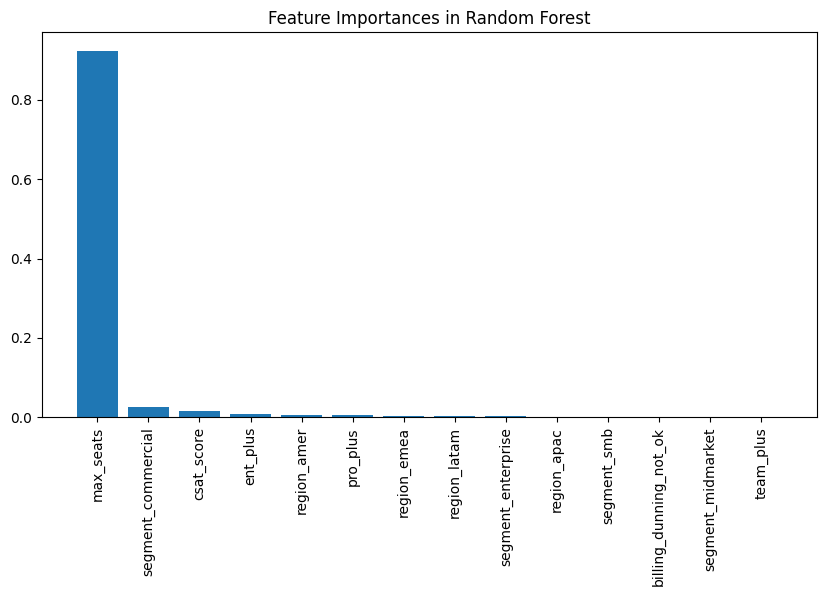

In [140]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[sorted_indices], rotation=90)
plt.title("Feature Importances in Random Forest")
plt.show()


### Ridge Regression

In [141]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_r2 = ridge.score(X_test, y_test)
print(f"Ridge Regression R²: {ridge_r2:.2f}")


Ridge Regression R²: 0.89


### Feature Impact Analysis: Removing 'max_seats'

In [142]:
X_train_new = X_train.drop(columns=['max_seats'])
X_test_new = X_test.drop(columns=['max_seats'])

rf_new = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_new.fit(X_train_new, y_train)

y_pred_rf_new = rf_new.predict(X_test_new)
print(f"New R2 Score without 'max_seats': {r2_score(y_test, y_pred_rf_new):.2f}")


New R2 Score without 'max_seats': 0.58
